<a href="https://colab.research.google.com/github/kopreusz/Linear-Regression/blob/main/ALKSTAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alkalmazott Statisztika Projekt: Regresszió

Ez az alkalmazott statisztika projektem, melyben egy diabétesszel kapcsolatos adatbázis alapján megpróbálok regressziót alkalmazni annak eldöntésére, hogy egy tetszőleges betegnél az adatok felvétele után mennyire becsülhetjük a betegség előrehaladottsági fokát. Lineáris modellt próbálunk illeszteni az adatbázisra és azzal a feltételezésel vágunk neki a feladatnak, hogy találunk olyan változókat, melyek lineárisan függennek a becsülendő értéktől.

# A kódról

Bár e könytárakat korábban már használtam, ezek közül számos meghívását már elfelejtettem. Ezekben az esetekben gyakran fordultam a bing copilot-hoz, azonban kiértékeléssel, elmélettel kapcsolatos kérdések megválaszolására nem hívtam segítségül. E válaszok (a lehetséges hibákkal egyetemben) a rendelkezésemre álló anyagból, saját kútfőből és python dokumentációkból szereztem, a forrásokat a munka során igyekeztem feltüntetni.

# Az adatbázis és néhány megjegyzés

A Regresszós modell alkalmazhatósága akkor lehetséges, ha föltételezhetjük a homoszkedasztikusságot a modell hibatagjairól, illetve a a hibatagok nem mutatnak autokorrelációt. Ennek ellenőrzése érdekében a homoszkedasztikusság eldöntésére a Breusch-Pagan, míg az autokorreláció vizsgálatára a Durbin-Watson tesztet használjuk.


Fontos megjegyeznünk, hogy a továbbiakban minden, a felhasználó által választható paraméter úgy lett megválasztva, hogy a mondott teszteken "átmenjen" a modell.

 Az adatbázisunk 442 mintát tartalmaz, azonban a Durbin-Watson tábla összesen 200 mintáig és 20 regresszorig ad megfelelő végpontokat a tesztstatisztikánk olyan értékeire melyben elfogadhatónak tételezhetjük azt a nullhipotézist, hogy a hibatagok nem autokorreláltak. A Durbin-Watson tábla vizsgálata után ugyan bizonyos monotonitás az intervallumok végpontjaira érzékelhető és talán fel is tételezhető, a mi esetünkben, több vizsgálat után is gyakran történt, hogy éppen csak elfogadhatónak tekinthettük azt az állítást, hogy a modellünk autokorrelációtól mentes, így, hogy könnyen ellenőrizhető legyen e feltétel 198 mintával dolgoztunk. E 198 minta kiválasztása egy a scikit-learn csomagba épített train-test-split nevű függvénnyel történt, mely keresztvalidációnál alkalmazandó. A test_size változó beállításával adhatjuk meg, hogy az adatbázis mekkora része kerüljön abba a halmazba, melyre a modellt építjük és mekkora része kerüljön abba, mellyel ellenőrizzük a modellt. E paraméter $0.55$-re való állítása adta a véletlenszerűen kivállasztott $198$ mintát.
Most bemutatjuk a háttérváltozókat:


*   age: A beteg kora.
*   sex: A beteg neme.
*   bmi: A beteg bmi indexe.
*   bp: Átlagos vérnyomás.
*   s1: A beteg koleszterinszintje.
*   s2: Alacsony sűrűségű lipoproteinszint.
*   s3: Magas sűrűségű lipoproteinszint.
*   s4: Teljes koleszterin
*   s5: Lehetséges triglicerid szint.
*   s6: Vércukorszint.
* target: A központi változó, mely méri a diabétesz előrehaladottságát az előző évi szinthez viszonyítva.



Szükséges könyvtárak meghívása:

In [ ]:
import pandas as pd                                           # A python adatbáziskezelő könyvtára.
import numpy as np                                            # Az alap könyvtár amivel csinálhatunk (lineáris)algebrát.
from sklearn.linear_model import LinearRegression             # A Regressziót tartalmazó könyvtár.
from sklearn.model_selection import train_test_split          # Keresztvalidáció.
from sklearn.datasets import load_diabetes                    # Az adatbázis.
import statsmodels.api as sm                                  # Statisztikai könyvtár.
from statsmodels.stats.stattools import durbin_watson         # Durbin-Watson teszt.
from statsmodels.stats.diagnostic import het_breuschpagan     # Breusch-Pagan teszt.
import matplotlib.pyplot as plt                               # Ábrázoláshoz szükséges könyvtár.
import scipy.stats as stats

Adtbázis betöltése és tisztítása, azokat a sorokat, melyeknél van hiányos adat kidobjuk. A függő változónak az adatbázis 'target' változóját választjuk.

In [ ]:
diabetes = load_diabetes()                                              # Az adatbázis betöltése.
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)        # DataFrame-mé konvertálás, ebben a formában szokásos kezelni egy adatbázist pythonban.
df = df.dropna()                                                        # Azon sorokat, ahol nincs adat kidobjuk.
df['target'] = diabetes.target                                          # A regresszió függő változójának kiválasztása.

Kiválasztjuk a magyarázó változókat, ezekről a későbbiekben írunk, és keresztvalidációt alkalmazunk. A bevezetőben mondottak alapján. Ezt követi a modell illesztés, melyre a scikit-learn beépített lineáris regressziós modeljét használjuk. A keresztvalidációnak még egy haszna van: A fenmmaradó tesztadatbázis tagjait felhasználhatjuk a hibák kiszámítására, melyen a függőváltozó becsült és mért értékek közötti eltérést értjük.

#Magyarázóváltozók kiválasztása tagok elhagyhatóságának tesztelésével:

Első lépésként megvizsgáljuk mely változókra érdemes a modellt építeni. Kezdetben az összeset bevesszük a modellbe, majd teszteljük 1-1 tag elhagyhatóságát. Most felépítjük a modellt az összes változóra.


In [ ]:
X = df.drop(['target'],axis=1)                                                                                   #Kezdetben minde lehetséges magyarézóváltozót bevezsünk a modellbe.
y = df['target']                                                                                                 # A függő változó.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.55, random_state=95)                       # Keresztvalidáció alkalmazása. a random state paraméter azért felel, hogy kiválaszthassuk ugyan ezen mintákat később is.
model = LinearRegression()                                                                                       # Modellválasztás.
model.fit(X_train, y_train)                                                                                      # Modellillesztés.
X_train_OSL = sm.add_constant(X_train)                                                                           # Ez egy technikai lépés, az sm könyvtár regressziós modelljében a tengelymetszet meghatározásánal lehetőségét biztosítja.
OLS = sm.OLS(y_train, X_train_OSL).fit()                                                                         # Az sm könytár regresszióra vonatkozó összefoglalója (itt kicsit "béna" hogy kétszer is illesztünk lineáris modellt, sk-leanrben ez nem volt ilyen mélységben elérhető)
print(OLS.summary())



                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     28.00
Date:                Tue, 24 Dec 2024   Prob (F-statistic):           3.21e-32
Time:                        14:18:01   Log-Likelihood:                -1051.6
No. Observations:                 198   AIC:                             2125.
Df Residuals:                     187   BIC:                             2161.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        153.6384      3.623     42.405      0.0

Az összefoglaló "P>|t|" oszlopában láthatók a magyarázó változó elhagyhatóságára vonatkozó próbák p-értékei. Itt 95% begbízhatósági szinten vizsgáljuk azt a nullhipotézisét, ami szerint a $k$-adik regresszor együtthatója nulla. A következő stratégiát követjük: Azt a magyarázóváltozót, melyre a legmagasabb a p-érték és még statisztikailag szignifikáns bizonyítékunk van az elhagyhatóságra, elhagyjuk a modellből. Jelen esetben ez az 'age' változó. Ez után eggyel kevesebb változóra ilesztünk modellt, ismét megnézzük az összefoglalót és a folyamatot addig ismételjük, míg csak olyan változók maradnak a modellben melyek esetén nincs szignifikáns bizonyíték, mely indokoná azok elhagyását. Ezen kívül a táblázat "std error" oszlopát is nézzük, ez az együttható lehetséges becsült értékeinek szórását tartalmazza. Ugyan megeshet, hogy magas p-értéket találunk, de a szórás is magas, a következőt követjük: A summary-t figyelembe véve igyekszünk olyan magyarázóváltozókat keresni, melyekkel "át tudonk menni" a Breusch-Pagan és DW teszteken (lásd a későbbiek) és ha lehetőségünk van csak olyanokat eldobni, melyek eldobhatósága statisztikai módszereink alapján föltételezhető. A folyamatot itt nem írjuk le lépésről lépésre, csak a végeredményt közöljük.

In [ ]:
X = df[['bmi','s1','sex','s2','s3','s6']]                                                                        #Kezdetben minden lehetséges magyarézóváltozót bevezsünk a modellbe.
y = df['target']                                                                                                 # A függő változó.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.55, random_state=95)                       # Keresztvalidáció alkalmazása. a random state paraméter azért felel, hogy kiválaszthassuk ugyan ezen mintákat később is.
model = LinearRegression()                                                                                       # Modellválasztás.
model.fit(X_train, y_train)                                                                                      # Modellillesztés.
X_train_OSL = sm.add_constant(X_train)                                                                           # Ez egy technikai lépés, az sm könyvtár regressziós modelljében a tengelymetszet meghatározásánal lehetőségét biztosítja.
OLS = sm.OLS(y_train, X_train_OSL).fit()                                                                         # Az sm könytár regresszióra vonatkozó összefoglalója (itt kicsit "béna" hogy kétszer is illesztünk lineáris modellt, sk-leanrben ez nem volt ilyen mélységben elérhető)
print(OLS.summary())


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     31.01
Date:                Tue, 24 Dec 2024   Prob (F-statistic):           7.28e-26
Time:                        14:18:01   Log-Likelihood:                -1074.9
No. Observations:                 198   AIC:                             2164.
Df Residuals:                     191   BIC:                             2187.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.4412      4.018     37.941      0.0

In [ ]:
y_pred = model.predict(X_test)
res = y_test - y_pred

Tehát a hibákat a
$$res = \underline{y}-\underline{a}X$$ képlet adja, ahol tehát $a_i$-k a regresszorok együtthatói.

# Durbin-Watson teszt
Itt nagyrészt a Durbin-Watson tesztről szóló wikipédiacikket követem, mely ezen a linken érhető el: https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic


A Durbin Watson teszt a reziduális hibák autokorellációjának mérésére szolgál, segítségével eldönthetjük, hogy feltételezhető-e autokorreláció mintákban. A tesztstatisztika egy $0$ és $4$ közötti értéket ad eredményül, ahol a $2$-es érték azt jelenti, hogy nem célszerű autokorrelációt tételezni, a $2$-nél kisebb értékek negatív, míg a $2$-nél nagyobb értékek pozitív autokorreláció feltételezésére adnak okot.
Arra, hogy mikor tételezhetjük föl e jelenségtől való mentességet a Durbin-Watson táblázat tartalmazza, mely a következő linken érhető el:
https://www3.nd.edu/~wevans1/econ30331/durbin_watson_tables.pdf
Itt $5$%-os szignifikanciaszinten teszteljük azt a nullhipotézist, hogy nincs autokorreláció a hibatagokban. Ehhez a tesztstatisztika értékének a táblázatba foglalt $dL$ és $dU$ értékek közé kell esnie $k'$ darab regresszor esetén.
Sajnos a p-érték kiíratás nincsen implementálva e csomagban, így ezt most mellőzzük.


Most már készen állunk a Durbin-Watson teszt elvégzésére:

In [ ]:
dw = durbin_watson(res)
print(f'Durbin-Watson statisztika értéke: {dw}') # FONTOS: Sajnos nincs implementálva a p-érték a DW-teszthez a csomagban és több keresés után sem találtam rá kódot, sem megfelelő magyarázatot a miértjére.

Durbin-Watson statisztika értéke: 1.7121306239040615


A fenti cella futtatását követően a Durbin-Watson teszt-statisztika értéke $1.7121306239040615$. A Durbin Watson tábla 200 regresszora tartalmaz megfelelő kritikus értékeket, mi most $198$-ra használjuk. Itt $dL= 1.697$ és $dU = 1.841$, illetve $150$ regresszorra ugyan ezen értékek rendre $1.637$ és $1.832$
azt is tudjuk, hogy a tesztstatisztika $\chi^2$ eloszlású, így monotonitási meggondolások mentén eljuthatunk a következtetésre, hogy tesztstatisztikánk
$1.7121306239040615$-as értéke statisztikailag szignifikáns bizonyíték arra, hogy ne tételezzünk fel autokorrelációt hibatagokban.

# Breusch-Pagan teszt

A következő lépés a homoszkedasztikusság vizsgálata. Ehhez a Breusch-Pagan tesztet hívjuk segítségül. Itt ha a teszt statisztikához tartozó $p$ érték $5$% alatt van elutasítjuk a homoszkedasztikusságot feltételező nullhipotézist és heteroszkedasztikusságot tételezünk, a Breusch-Pagan tesztről szóló wikipédiacikk alapján, mely a következő linken érhető el:
https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test

In [ ]:
X_test_const = sm.add_constant(X_test)
_, pval, __, f_pval = het_breuschpagan(res, X_test_const)
print(f'Breusch-Pagan p-érték: {pval}')

Breusch-Pagan p-érték: 0.21558669530387178


Tehát $$p>0.05,$$
így nem találtunk statisztikailag szignifikáns bizonyítékot a homoszkedasztikusság feltételezése ellen, innen és a Durbin-Watson próbánál látottak alapján legitimáltuk a Lineáris regressziós modell használatát.

# A Modellépítséről

Megjegyezzük, hogy amit eddig láthatott az olvasó az sok vizsgálat és próbálkozás eddigi eredménye. A modellépítést gyakorlatilag úgy végeztük, hogy az előző három alfejezet lépéseit ismételgettük különböző magyarázóváltozók használatával összefoglalva tehát a következő 3 feltételt figyelembe véve (melyek sajnos egyidejűleg általában nem teljesültek):
*    A kiválasztott magyarázóváltozók szükségesek a modellépítéshez és törekedünk minden olyat kidobni, melyre statisztikailag szignifikáns bizonyítékunk van.
*   A modellről föltételezhető, hogy autokorrelációtól mentes.
*   Teljesül a homoszkedsztikusságra vonatkozó feltétel.

# A modell kiértékelése:

Mielőtt bárminek nekivágnánk jelezzük, hogy két olyan magyarázóváltozót is eldobtunk, melynek elhagyásának lehetőségére nincs szignifikáns bizonyítékunk. Mégis azért döntöttünk így, mert a többi próbálkozásunk esetében a lineáris modell alkalmazhatósága nem lett volna indokolt a DW és BP- tesztek eredményei alapján.

In [ ]:
from sklearn.metrics import r2_score
score = r2_score(y_test, y_pred)
print(f'R^2= {score}')
score2 = r2_score(y_train, model.predict(X_train))
print(f'R^2= {score2}')

R^2= 0.4344443909808774
R^2= 0.49341663688879656


A cella futtatás után láthatjuk, hogy $$R^2 = 0.4344443909808774$$

$$R^2 = 1-\frac{\sum(Y_i-\hat{Y})^2}{\sum (Y_i-\overline{Y})^2}$$




A reziduális négyzetösszeg minimalizálásával adodóan a modell a teljes variancia ekkora részét magyarázza.

 Kérdés, hogy ez jó-e?
Megkísérlünk néhány javítást, s ha ez nem is feltétlen sikerül, valamiféle magyarázatot keresünk e jelenségre, esetleg megpróbálkozunk polinomiális regresszióval is.

# Jobb R^2 nyomában


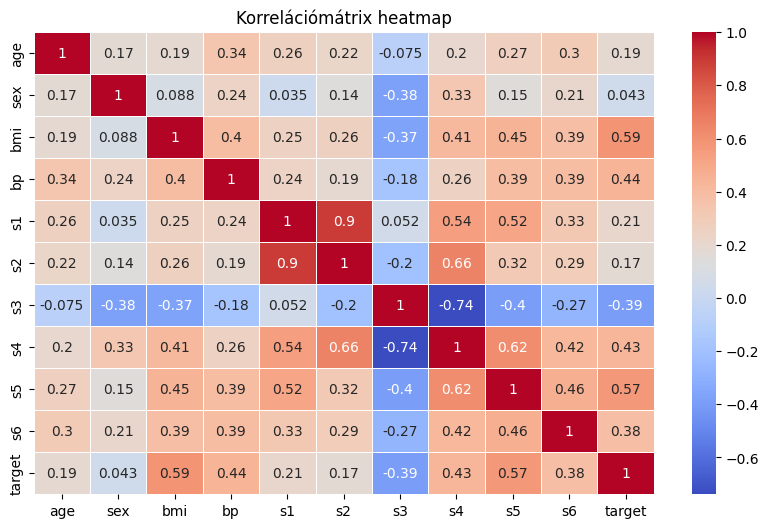

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_mtx = df.corr()                                                          # Ez a korrelációmátrix, a heatmap az átláthatóságért van, akár itt ki is irathatnánk.
plt.figure(figsize=(10, 6))
sns.heatmap(corr_mtx, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Korrelációmátrix heatmap')
plt.show()


A korrelációmátrixból látható, hogy alig akad olyan változó mely erős lineáris kapcsolatot mutatna a targettel. Így meglehet, hogy a lineáris modell nem a legjobb választás. Ezt a következő ábrák is sejtetik:


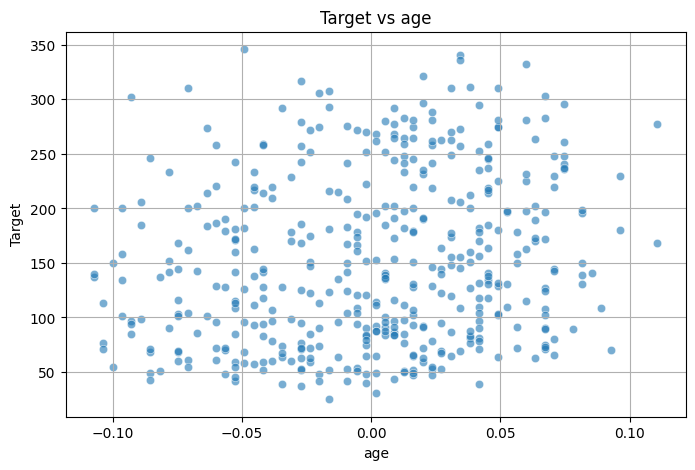

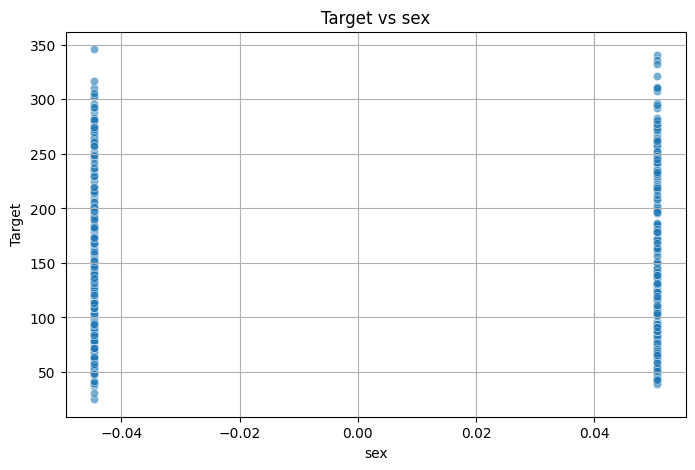

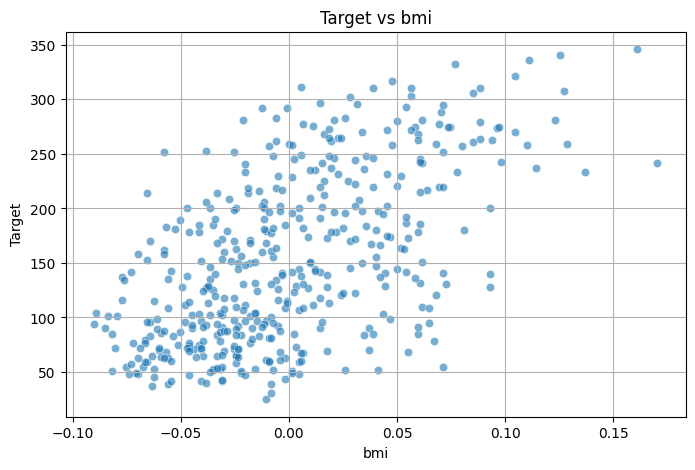

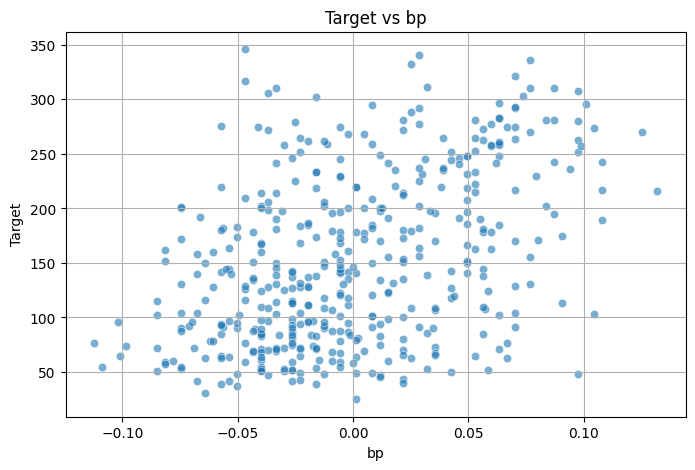

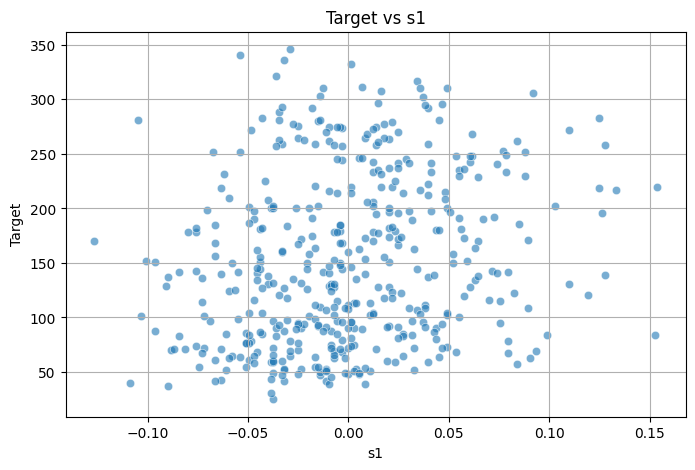

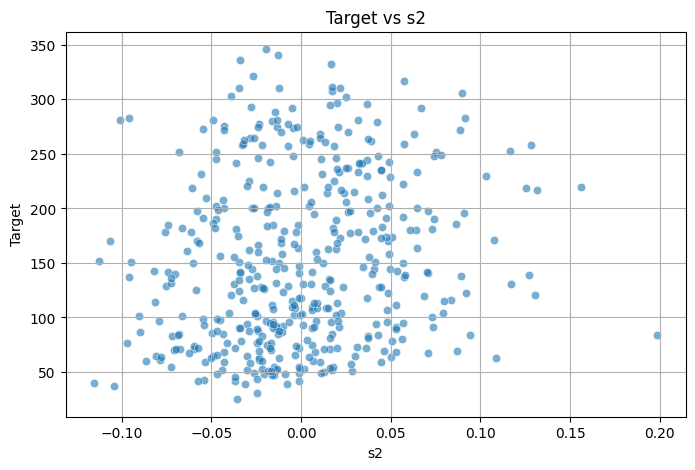

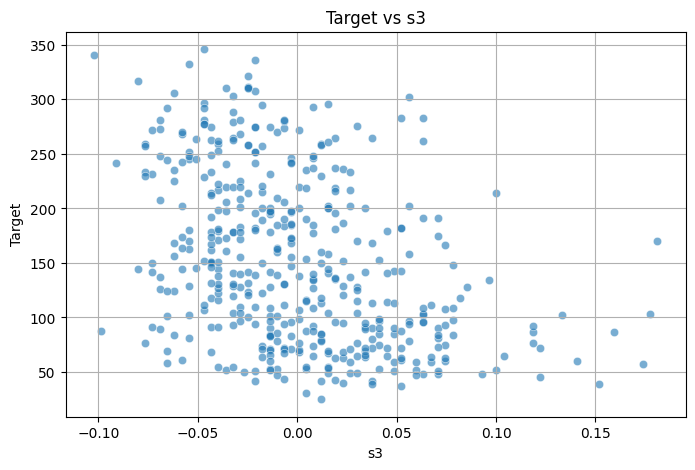

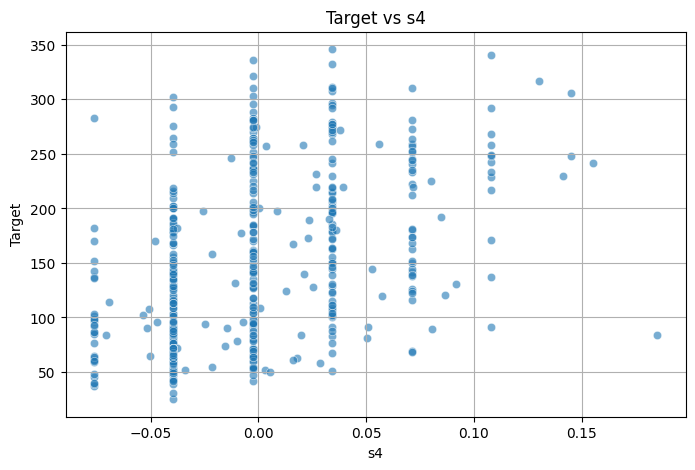

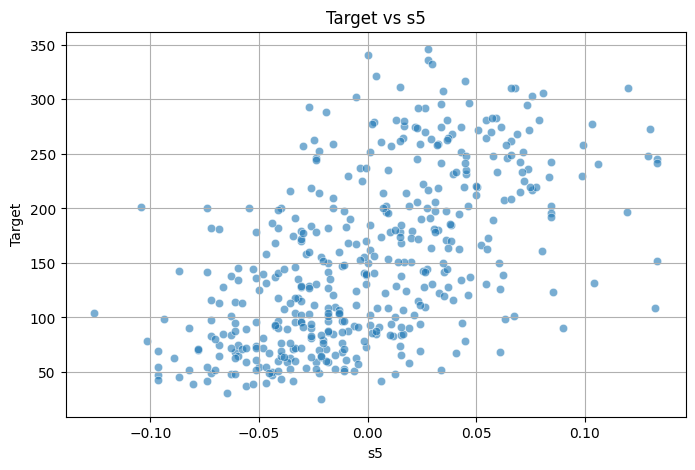

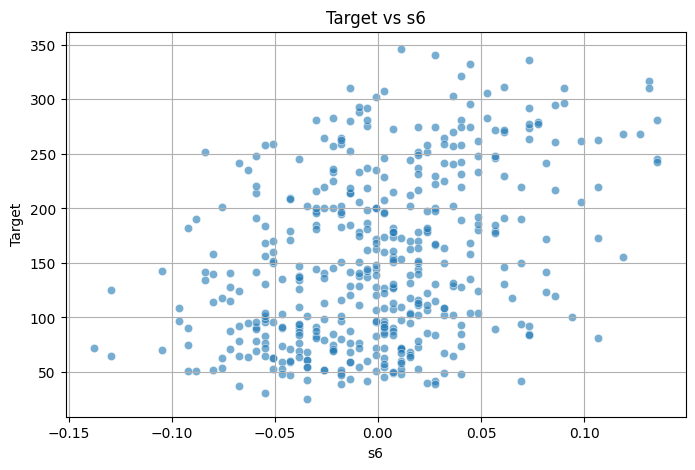

In [ ]:
for column in df.drop('target', axis=1).columns:
    plt.figure(figsize=(8, 5))
    plt.scatter(df[column], df['target'], alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.xlabel(column)
    plt.ylabel('Target')
    plt.title(f'Target vs {column}')
    plt.grid(True)
    plt.show()


# Logaritmikus skálára való áttérés

Még megkiséreljük a target logaritmikus skálával való felírását.
és az eddig említett lépéseket elvégezzük. A következő kódot nem magyarázzuk, ugyan úgy történik minden, mint az imént, csupán a target értékek logaritmusát vesszük a továbbiakban, jobb $R^2$ reményében.

In [ ]:
X = df.drop(['target','age','s4'],axis=1)
y = np.log(df['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.55, random_state=95)
model = LinearRegression()
model.fit(X_train, y_train)
X_train_OSL = sm.add_constant(X_train)
OLS = sm.OLS(y_train, X_train_OSL).fit()
print(OLS.summary())

y_pred = model.predict(X_test)
res = y_test - y_pred
dw = durbin_watson(res)
print(f'Durbin-Watson statisztika értéke: {dw}')
X_test_const = sm.add_constant(X_test)
_, pval, __, f_pval = het_breuschpagan(res, X_test_const)
print(f'Breusch-Pagan p-érték: {pval}')



                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     27.81
Date:                Tue, 24 Dec 2024   Prob (F-statistic):           2.86e-28
Time:                        14:18:10   Log-Likelihood:                -90.381
No. Observations:                 198   AIC:                             198.8
Df Residuals:                     189   BIC:                             228.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8878      0.028    174.543      0.0

A most alkalmazott áttérés $0.541$-es $R^2$-et eredményezett, ami egy fokkal jobb, mint a korábbiak. A DW teszten átmegy a modell, az ide tartozó felső korlát 1.863, ami még éppen belefér, a Breusch-Paganon a p-értékünk most $0.0625$ körüli. Összeségében sikerült javítanunk a logaritmikus skálára való áttéréssel.

# PCA adatvizualizációra

Most megkiséreljük az adathalmaz ábrázolását 2 dimenzióban. Ehhez segítségülhívunk egy PCA-t, majd ábrázoljuk az adatbázist.



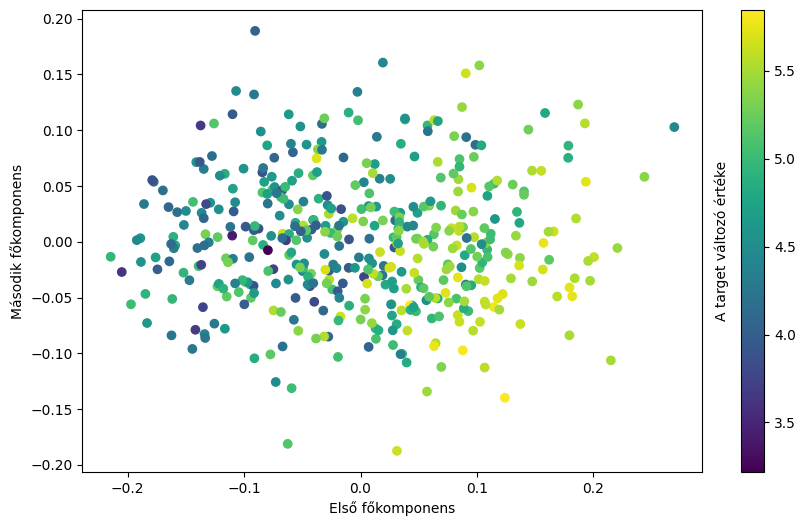

0.5516530427751476
Principal Components Matrix:
          age       sex       bmi        bp        s1        s2        s3  \
PC1  0.216431  0.186967  0.303162  0.271738  0.343255  0.351861 -0.282437   
PC2  0.044367 -0.386547 -0.156281 -0.138266  0.573027  0.455942  0.506239   

           s4        s5        s6  
PC1  0.428834  0.378618  0.322183  
PC2 -0.068181 -0.026187 -0.084949  


In [ ]:

from sklearn.decomposition import PCA

diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df = df.dropna()
df['target'] = diabetes.target

data = df.drop(['target'],axis=1)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Target'] = np.log(df['target'])

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Target'], cmap='viridis')
plt.colorbar(scatter)
plt.text(1.02, 0.5, 'A target változó értéke', transform=plt.gca().transAxes, va='center', ha='left',rotation=90)
plt.xlabel('Első főkomponens')
plt.ylabel('Második főkomponens')
plt.show()
print(np.sum(pca.explained_variance_ratio_))

principal_components_matrix = pca.components_
components_df = pd.DataFrame(principal_components_matrix, columns=data.columns, index=[f'PC{i+1}' for i in range(principal_components_matrix.shape[0])])

# Display the principal components
print("Principal Components Matrix:")
print(components_df)



Bár a totális varianciának kicsit több, mint a felét magyarázza a dimenziócsökkentett adathalmaz (ez nem az igazi) arra való tekintettel, hogy az elhagyott dimenziókon mért variancia monoton növő sorozatot alkot az itt "látható" főtengelyek irányába a lehető legnagyobb a szórás. Ez az ábra is sejteti, hogy nehéz lesz kimondottan erős lineáris kapcsolatot találni, bár az első főkomponens mentén "érzékelhető" a linearitás, a második mentén látható, hogy körülbelül azonos mértékben fordulnak elő a target érték szélsőértékeihez is közeli adatotok. Ennek mélyebb vizsgálata érdekében kezdetben teszteljük a főkomponensek és a target függetlenségét, a target folytonos, a főkomponens nagysága, mint véletlen változóról most feltesszük. (mi van, ha diszkrétek és folytonosok is kerülnek a főkomponensbe??)
Spearmann korreláció tesztet alkalmazunk:

In [ ]:

stat1, p_val1 = stats.spearmanr(pca_df['PC1'],pca_df['Target'])
stat2, p_val2 = stats.spearmanr(pca_df['PC2'],pca_df['Target'])

print(p_val1)
print(stat1)
print(p_val2)
print(stat2)

3.492640872099571e-38
0.5621210947374815
0.00015915838656703672
-0.17867997515360728


Itt 5%-os szignifikanciaszinten teszteljük azt a nullhipotézist, hogy a target változó és a PCA-val transzformált adathalmaz változói függetlenek. Mindkét esetben $p<0.05$, így elutasítjuk a nullhipotézist. A sejtésben megfogalmazott esetben találjuk a legmagasabb Spearman-féle korrelációs együtthatót, melynek értéke körülbelül $0.56$, ami szintén mutatja, hogy kimondottan erős lineáris kapcsolatot nem találtunk, még a transzformált adathalmaz esetén sem, azonban m kizárni sem tudjuk a lineáris függés lehetőségét.